# Padaria Portugesa Geolocation

In [2]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import geopandas as gp
import geoplot as gplt

In [7]:
freguesias = gp.read_file('data/freguesias.shp')
padarias = pd.read_csv('data/padarias.csv', index_col=0)

In [5]:
freguesias = freguesias[['NOME', 'AREA_M2', 'geometry']]

In [14]:
points = padarias[['restaurant.location.latitude', 'restaurant.location.longitude']]

In [16]:
geosales = gp.GeoDataFrame(sales[sales.latitude.isnull() == False], geometry=gp.points_from_xy(sales[sales.latitude.isnull() == False].longitude, sales[sales.latitude.isnull() == False].latitude))

restaurant.location.latitude     0
restaurant.location.longitude    0
dtype: int64

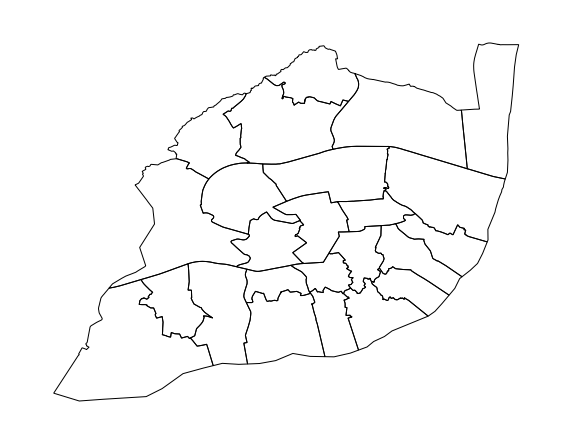

In [10]:
# get exterior of multipolygons
exterior = freguesias.unary_union
    
# remove points outside the city
#poi = [point for point in poi if point.within(exterior)]
           
# plot figure to see input data
ax = gplt.polyplot(freguesias, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);

#for p in poi:  
    #ax.scatter(p.x, p.y, facecolor='r', edgecolor='k', s=50);
#ax.set_title('Area Boundary and Points of Interest')
#plt.tight_layout()

In [23]:
geosales = gp.GeoDataFrame(sales[sales.latitude.isnull() == False], geometry=gp.points_from_xy(sales[sales.latitude.isnull() == False].longitude, sales[sales.latitude.isnull() == False].latitude))